GPT Vision Notebook / Shriya Natarajan

GPT-Vision-invasive-plants.ipynb / https://colab.research.google.com/drive/117xvg6u9BoO2YQ2mjArxJcJgdO-7N6ac


In [ ]:
pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.7/862.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [ ]:
import anthropic
import base64
import httpx

In [ ]:
from google.colab import drive
import pandas as pd
import json
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from google.colab import userdata


In [ ]:
client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key= userdata.get('CLAUDE_KEY')
)

MODEL = "claude-3-haiku-20240307"
#MODEL = "claude-3-opus-20240229"

In [ ]:
message = client.messages.create(
    model= "claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {
                    "type": "text",
                    "text": "Describe this image."
                }
            ],
        }
    ],
)
print(message)

Message(id='msg_0198G1QYpjjPZiePAw3wcTYD', content=[TextBlock(text="This image shows a close-up view of a black ant. The ant appears to be on a textured surface, possibly a piece of wood or concrete. The ant's body is black and shiny, with distinct features such as its long legs, antennae, and eyes visible. The background is out of focus, creating a soft, warm-toned atmosphere that highlights the intricate details of the ant's form.", type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=1552, output_tokens=90))


In [ ]:
# Check the code from current notebook
drive.mount('/content/gdrive')

#Change the path below to the file path
images = pd.read_csv('gdrive/My Drive/New Image CSV/NEWAll_Plants.csv', encoding= 'unicode_escape')
len(images)

Mounted at /content/gdrive


2500

In [ ]:
#Check the top rows
images.head()

,plant_name,image_url,latitude,longitude,profile_url
0,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,37.318328,-93.295312,https://www.inaturalist.org/observations/20492...
1,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,38.700655,-90.721412,https://www.inaturalist.org/observations/20493...
2,Autumn Olive,https://static.inaturalist.org/photos/36228599...,38.830053,-94.744653,https://www.inaturalist.org/observations/20493...
3,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.596591,-82.306213,https://www.inaturalist.org/observations/20493...
4,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.217080,-85.134268,https://www.inaturalist.org/observations/20493...


In [ ]:
zero_shot_sys = '''You are designed to detect if the attached image of a plant has an one of 10 plant species.

The list of 10  species we are interested in are Autumn Olive, Black Swallow Wort, Common Reed, Garlic Mustard, Japanese Barberry, Japanese Knotweed, Mile a minute, Mugwort, Multiflora rose, and Oriental Bittersweet

You will return a JSON indicating the plant most likely in the picture if any and the probability like this {"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"}

Please do not include any text other than the JSON response.'''


zero_shot_prompt='''Is  one of the  10 plants in this image?'''

In [ ]:
# Helper function to ChatGPT and get the JSON response.
def json_gpt(sys_prompt: str, user_prompt: str, image_url: str):
  try:
        image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

        messages=[{"role": "user",
            "content": [{"type": "image","source":
                     {"type": "base64","media_type": "image/jpeg" ,"data": image_data,},
                        },
                {"type": "text", "text": user_prompt}
                ],
            }
        ]
        completion = client.messages.create(
          model= MODEL,
          system=sys_prompt,
          max_tokens=1024,
          messages= messages,
        )

        print(completion)
        text = completion.content[0].text
        print(text)
        parsed = json.loads(text)

        return parsed
  except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Assuming 'images' DataFrame already exists
# Add a column for predicted labels to the DataFrame
images['predicted_label'] = None

for i, row in images.head(2500).iterrows():
    print("Processing:", row["plant_name"], row["image_url"])
    result = json_gpt(zero_shot_sys, zero_shot_prompt, row["image_url"])
    if result:
        print("Result:", result)
        # Use result.get with a default value of "Unknown" for cases where the model returns no prediction
        plant_name = result.get("plant_name", None)
        if not plant_name:  # This checks for both None and empty string cases
            plant_name = "Unknown"
        images.at[i, 'predicted_label'] = plant_name
    else:
        print("Failed to get a result.")
        images.at[i, 'predicted_label'] = "Unknown"  # Handle failed predictions


Streaming output truncated to the last 5000 lines.
Message(id='msg_01XdiEovyLLhYLqMpQEU4Hr7', content=[TextBlock(text='{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".90"}', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=426, output_tokens=26))
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".90"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.90'}
Processing: Japanese Knotweed https://static.inaturalist.org/photos/365749443/medium.jpeg
Message(id='msg_01QMM812SYuVENbQQR9Bab1V', content=[TextBlock(text='{"found_plant":"yes", "plant_name":"Oriental Bittersweet", "probability":".85"}', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=426, output_tokens=28))
{"found_plant":"yes", "plant_name":"Oriental Bi

In [ ]:
# Initialize LabelEncoder
le = LabelEncoder()
image_predict = images.head(2500)

for i, row in image_predict.iterrows():
  if images.at[i, 'predicted_label'] == None:
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'none':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Multiflora rose':
      images.at[i, 'predicted_label'] = 'Multiflora Rose'
  if images.at[i, 'predicted_label'] == 'Mile a minute':
      images.at[i, 'predicted_label'] = 'Mile A Minute'
  if images.at[i, 'predicted_label'] == 'Mile M Minute':
      images.at[i, 'predicted_label'] = 'Mile A Minute'
  if images.at[i, 'predicted_label'] == 'Japanese Honeysuckle':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Unkown':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Mile A Minute':
      images.at[i, 'predicted_label'] = 'Mile-A-Minute'
  if images.at[i, 'predicted_label'] == 'unknown':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Honeysuckle':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Olive':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'common reed':
      images.at[i, 'predicted_label'] = 'Common Reed'
  if images.at[i, 'predicted_label'] == 'N/A':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'n/a':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None of the 10 listed plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Ground ivy':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Garlic mustard':
      images.at[i, 'predicted_label'] = 'Garlic Mustard'
  if images.at[i, 'predicted_label'] == 'not found':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Wintergreen':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Goji berry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Forsythia':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Barberry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Japanese barberry':
      images.at[i, 'predicted_label'] = 'Japanese Barberry'
  if images.at[i, 'predicted_label'] == 'Clover':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Skunk cabbage':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Skunk Cabbage':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Japanese knotweed':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None of the 10 specified plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'none of the 10 specified plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'not identified':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Moss':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Fern':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Common Nightshade':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'English Ivy':
      images.at[i, 'predicted_label'] = 'Unknown'


# Collect unique plant names from the 'plant_name' column
unique_plant_names = images['plant_name'].unique().tolist()

# Ensure "Unknown" is included in the list of unique plant names
if "Unknown" not in unique_plant_names:
    unique_plant_names.append("Unknown")

# Fit the LabelEncoder with this updated list of plant names
le.fit(unique_plant_names)

print(unique_plant_names)
print(image_predict['plant_name'].unique())

print(image_predict['predicted_label'].unique())

# Transform the actual plant names to their encoded values
image_predict['actual_encoded'] = le.transform(image_predict['plant_name'])

# Transform the predicted labels to their encoded values
# This step now works correctly because "Unknown" is recognized by the encoder
image_predict['predicted_encoded'] = le.transform(image_predict['predicted_label'])


['Autumn Olive', 'Black Swallow Wort', 'Common Reed', 'Garlic Mustard', 'Japanese Barberry', 'Japanese Knotweed', 'Mile-A-Minute', 'Mugwort', 'Multiflora Rose', 'Oriental Bittersweet', 'Unknown']
['Autumn Olive' 'Black Swallow Wort' 'Common Reed' 'Garlic Mustard'
 'Japanese Barberry' 'Japanese Knotweed' 'Mile-A-Minute' 'Mugwort'
 'Multiflora Rose' 'Oriental Bittersweet']
['Garlic Mustard' 'Mugwort' 'Multiflora Rose' 'Oriental Bittersweet'
 'Unknown' 'Autumn Olive' 'Japanese Barberry' 'Common Reed'
 'Japanese Knotweed' 'Black Swallow Wort' 'Mile-A-Minute']


<ipython-input-48-f48e77a6c354>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_predict['actual_encoded'] = le.transform(image_predict['plant_name'])
<ipython-input-48-f48e77a6c354>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_predict['predicted_encoded'] = le.transform(image_predict['predicted_label'])


In [ ]:
print(image_predict['actual_encoded'])

0       0
1       0
2       0
3       0
4       0
       ..
2495    9
2496    9
2497    9
2498    9
2499    9
Name: actual_encoded, Length: 2500, dtype: int64


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(image_predict['actual_encoded'], image_predict['predicted_encoded'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.2936


In [ ]:
# Confusion Matrix
cm = confusion_matrix(image_predict['actual_encoded'], image_predict['predicted_encoded'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 24   0  44  51  16   3   0  40  36  16  20]
 [ 10   3  44  55   4  17   1  49  37  23   7]
 [  0   0 196   1   0   1   0   1   1   0  50]
 [  1   0  14 151   0   4   1  76   0   1   2]
 [ 27   0  29  40  58   2   0  26  32  14  22]
 [ 12   0  38  48   6  32   4  34  33  12  31]
 [  2   0  30 112   2  22   7  24  22  17  12]
 [  1   0  45  56   1   4   0 134   1   0   8]
 [  3   0  24  36  15   3   1  28 111  11  18]
 [  4   0  27  67   6   6   0  60  34  18  28]
 [  0   0   0   0   0   0   0   0   0   0   0]]


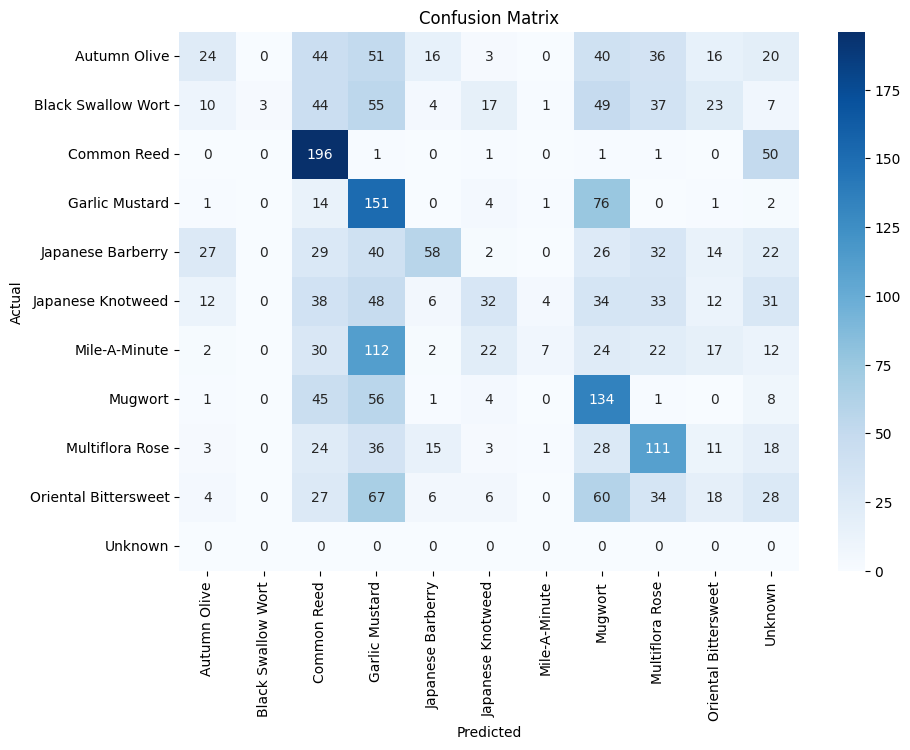

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

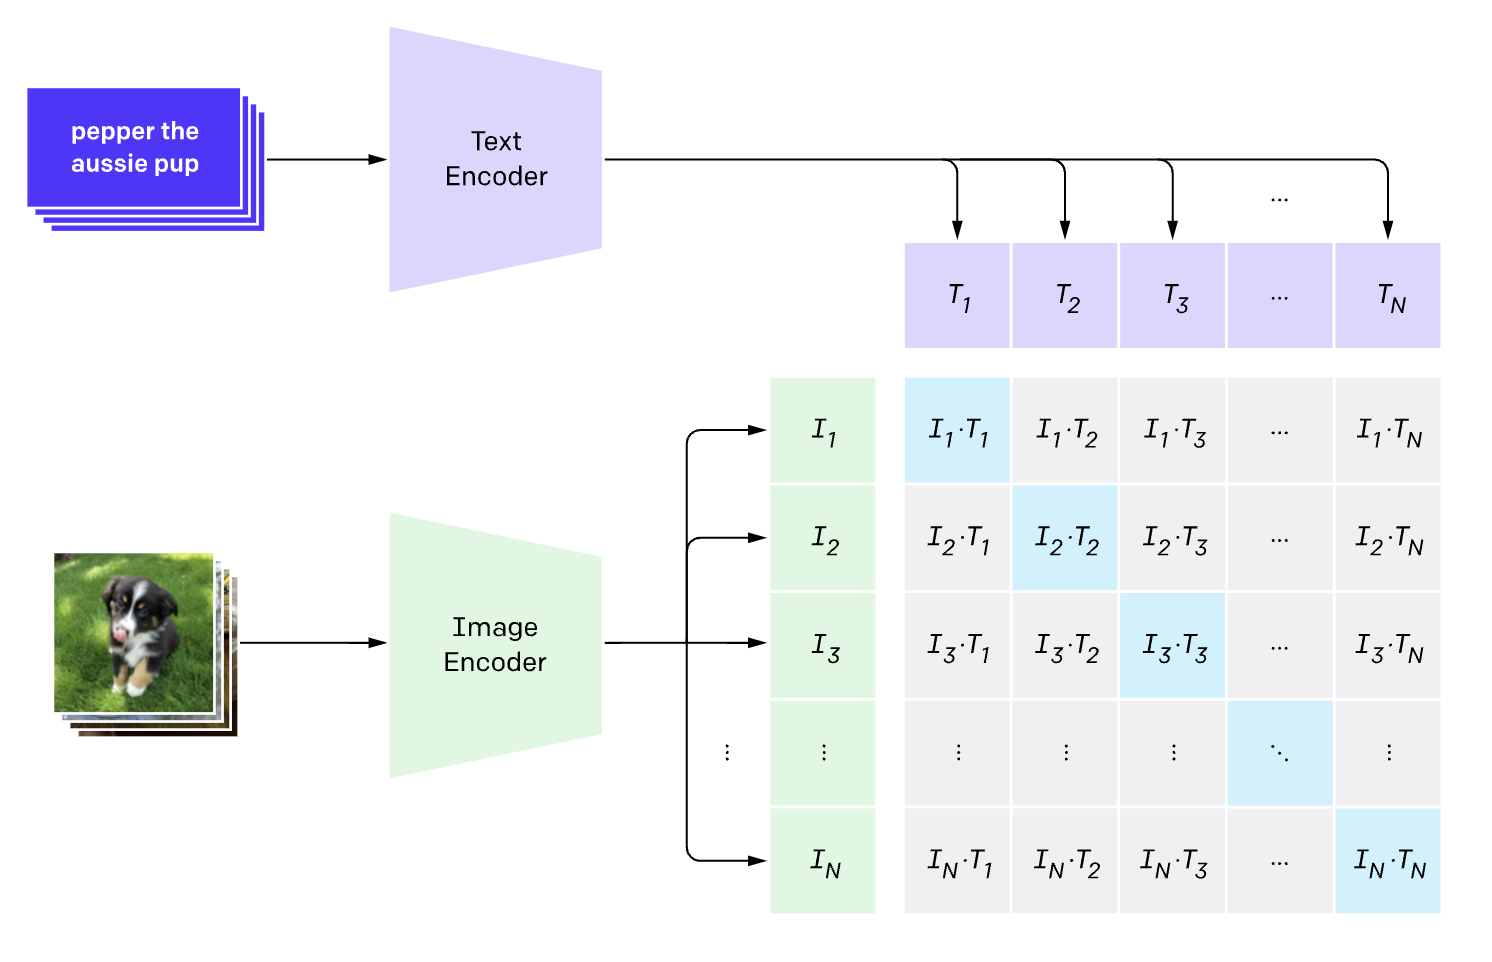

In [ ]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
librsvg2-bin is already the newest version (2.52.5+dfsg-3ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>